Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2696 - loss: 1.9295
Epoch 1: val_accuracy improved from -inf to 0.73684, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.2716 - loss: 1.9236 - val_accuracy: 0.7368 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7294 - loss: 0.7357
Epoch 2: val_accuracy improved from 0.73684 to 0.88158, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.7298 - loss: 0.7348 - val_accuracy: 0.8816 - val_loss: 0.3325 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8908 - loss: 0.3569
Epoch 3: val_accuracy improved from 0.88158 to 0.90351, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.8910 - loss: 0.3562 - val_accuracy: 0.9035 - val_loss: 0.2629 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.947

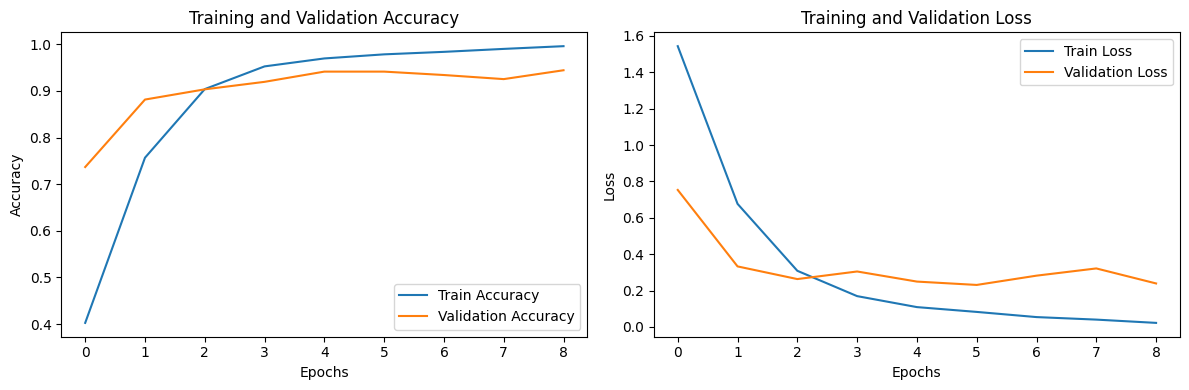

22/22 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


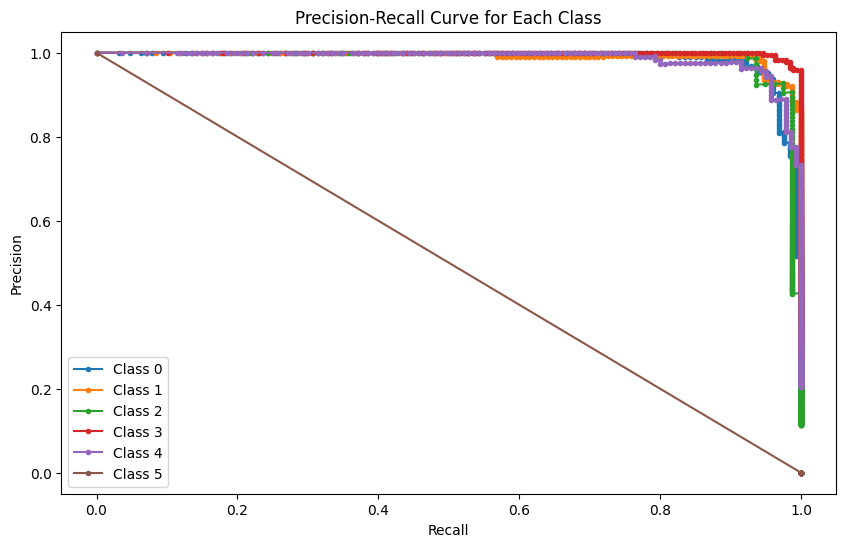


Classification Report:
An error occurred during training: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter


In [3]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

# Disable version check for albumentations
import albumentations.core.utils
albumentations.core.utils.check_version = lambda: None

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomResizedCrop(height=224, width=224, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Dataset expansion code
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            augmented = augmentations(image=img)["image"]
            cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
            images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

# Apply Processing Techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
            cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
            cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
            cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
            cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

# Data loading and splitting
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    if not os.path.exists(label_path):
        continue
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        if os.path.exists(img_path):
            all_images.append(img_path)
            all_labels.append(label_map[label])

if not all_images:
    raise Exception("No valid images found in the dataset")

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Data generator with ResNet50 preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Data generators with error handling
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

# Build ResNet50 model
def build_resnet_classifier(num_classes, fine_tune_layers=30):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze all layers except the last few
    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create and compile model
model = build_resnet_classifier(len(valid_labels))
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with error handling
try:
    # Add learning rate scheduler
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # Model checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',  # Updated extension to .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        class_weight=class_weight_dict,
        callbacks=[reduce_lr, early_stopping, checkpoint]
    )

    # Load best model
    model.load_weights('best_model.keras')  # Updated to .keras extension

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Test Loss: {test_loss:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()

    # Compute and plot PR curve
    num_classes = len(valid_labels)
    y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
    y_probs = model.predict(test_gen)

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend()
    plt.show()

    # Print classification report
    y_pred = np.argmax(y_probs, axis=1)
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(test_gen.classes, y_pred, 
                              target_names=[k for k, v in sorted(label_map.items(), key=lambda x: x[1])]))

except Exception as e:
    print(f"An error occurred during training: {e}")